# Dynamic Programming

## 4.1 Policy Evaluation (Prediction)

> _Exercise 4.1_ In Example 4.1, if $\pi$ is the equiprobable random policy, what is $q_\pi(11, \verb|down|)$? What is $q_\pi(7, \verb|down|)$?

$$
q_\pi(11, \verb|down|) = -1\\
q_\pi(7, \verb|down|) = \mathbb{E}_\pi[R_t + \gamma v_\pi(S_{t+1}) \;|\; S_t = 7, A_t = \verb|down|] = -1 + v_\pi(11) = -15
$$

> _Exercise 4.2_ In Example 4.1, suppose a new state 15 is added to the gridworld just below state 13, and its actions, $\verb|left|$, $\verb|up|$, $\verb|right|$, $\verb|down|$, take the agent to states 12, 13, 14, and 15, respectively. Assume that the transitions _from_ the original states are nichanged. What, then, is $v_\pi(15)$ for the equiprobable random policy? Now suppose the dynamics of state 13 are also changed, such that action $\verb|down|$ from state 13 takes the agent to the new state 15. What is $v_\pi(15)$ for the equiprobable random policy in this case?

In the first case, we can compute using the Bellman equation:

\begin{align}
v_\pi(15) &= \frac{1}{4}\big(v_\pi(12) + v_\pi(13) + v_\pi(14) + v_\pi(15)\big) \\
&= \frac{1}{4}\big(-22 + -20 + -14 + v_\pi(15)\big)\\
\Rightarrow \frac{3}{4}v_\pi(15) &= -14\\
\Rightarrow v_\pi(15) &= 18.\bar{6}
\end{align}

In the second case, we have to resolve for the value functions for every state using policy evaluation.

In [1]:
dictionary = Dict{Tuple{Int,Symbol},Int}()
for s in 1:14
    dictionary[(s, :left)] = s - 1
    dictionary[(s, :up)] = s - 4
    dictionary[(s, :right)] = s + 1
    dictionary[(s, :down)] = s + 4
end

for s in 1:3
    dictionary[(s, :up)] = s
end

for s in 12:14
    dictionary[(s, :down)] = s
end

for s in 4:4:12
    dictionary[(s, :left)] = s
end

for s in 3:4:11
    dictionary[(s, :right)] = s
end

dictionary[(4, :up)] = 0
dictionary[(1, :left)] = 0
dictionary[(14, :right)] = 0
dictionary[(11, :down)] = 0

function gridworld_dynamics(s, a, sp)
    return dictionary[(s-1, a)] == sp-1 ? 1 : 0
end

gridworld_dynamics (generic function with 1 method)

In [2]:
gridworld_dynamics(5, :up, 10)

0

In [3]:
gridworld_reward(s, a) = -1

gridworld_reward (generic function with 1 method)

In [4]:
struct MDP
    states::Vector{Int}
    terminal_states::Vector{Int}
    actions::Vector{Symbol}
    dynamics::Function
    reward::Function
    γ::Float64
end

In [5]:
gridworld = MDP(collect(1:15), [1], [:left, :up, :right, :down], gridworld_dynamics, gridworld_reward, 1)

MDP([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], [1], [:left, :up, :right, :down], gridworld_dynamics, gridworld_reward, 1.0)

In [144]:
function policy_evaluation(
        mdp::MDP,
        policy;
        init_V = zeros(length(mdp.states)),
        θ=0.01,
        iterations=1000)
    V = init_V
    δ = Inf
    N = 1
    while δ > θ && N < iterations
        Vp = copy(V)
        for s in mdp.states
            if s ∉ mdp.terminal_states
                Vp[s] = sum(policy(a, s)*mdp.dynamics(s, a, sp)*(mdp.reward(s, a) + mdp.γ*V[sp])
                    for a in mdp.actions, sp in mdp.states)
            end
        end
        δ = maximum(abs.(Vp .- V))
        V = Vp
        N += 1
    end
    return V
end

policy_evaluation (generic function with 1 method)

In [7]:
equiprobable_policy(a, s) = 0.25

equiprobable_policy (generic function with 1 method)

In [8]:
V = policy_evaluation(gridworld, equiprobable_policy; θ=eps(Float64))

15-element Vector{Float64}:
   0.0
 -13.999999999999986
 -19.99999999999998
 -21.99999999999997
 -13.999999999999988
 -17.999999999999982
 -19.99999999999998
 -19.99999999999998
 -19.99999999999998
 -19.99999999999998
 -17.999999999999982
 -13.999999999999986
 -21.99999999999997
 -19.99999999999998
 -13.999999999999986

In [9]:
function value_matrix(V)
    values = fill(V[1], (4, 4))
    values[1, 1] = values[4,4] = V[1]
    values[1, 2:4] = V[2:4]
    values[2, 1:4] = V[5:8]
    values[3, 1:4] = V[9:12]
    values[4, 1:3] = V[13:15]
    return values
end

value_matrix (generic function with 1 method)

In [10]:
value_matrix(V)

4×4 Matrix{Float64}:
   0.0  -14.0  -20.0  -22.0
 -14.0  -18.0  -20.0  -20.0
 -20.0  -20.0  -18.0  -14.0
 -22.0  -20.0  -14.0    0.0

In [11]:
dictionaryp = copy(dictionary)

dictionaryp[(15, :left)] = 12
dictionaryp[(15, :up)] = 13
dictionaryp[(15, :right)] = 14
#dictionaryp[(15, :down)] = 15

dictionaryp[(13, :down)] = 15

dictionaryp[(16, :left)] = 12
dictionaryp[(16, :up)] = 15
dictionaryp[(16, :right)] = 14
dictionaryp[(16, :down)] = 16

dictionaryp[(15, :down)] = 16

function gridworld_dynamicsp(s, a, sp)
    return dictionaryp[(s-1, a)] == sp-1 ? 1 : 0
end

gridworldp = MDP(collect(1:16), [1], [:left, :up, :right, :down], gridworld_dynamicsp, gridworld_reward, 1)

Vp = policy_evaluation(gridworldp, equiprobable_policy; θ=eps(Float64))

vcat(vcat(value_matrix(Vp), [0., Vp[16], 0., 0.]'), [0.0, Vp[16], 0., 0.0]')

6×4 Matrix{Float64}:
   0.0     -13.3436  -19.1542  -21.145
 -13.0358  -16.8766  -18.9739  -19.1357
 -18.2307  -18.1531  -16.7293  -13.2883
 -19.5033  -16.7758  -12.5017    0.0
   0.0     -12.9452    0.0       0.0
   0.0     -12.9452    0.0       0.0

$$
f(x) < g(x)
$$

> _Exercise 4.3_ What are the equations analogous to (4.3), (4.4), and (4.5) for the action-value function $q_\pi$ and its successive approximation by a sequence of of functions $q_0$, $q_1$, $q_2, \dots$?

$$
\begin{align}\tag{4.3}
q_\pi(s, a)&=\mathbb{E}_\pi[R_{t+1} + \gamma v_\pi(S_{t+1}))\mid S_{t}=s, A_t=a] \\\\\tag{4.4}
&=\sum_{r,s'}{p(s', r | s, a)(r + \gamma\sum_{a'}{\pi(a'|s')q_\pi(s', a'))}}\\\\\tag{4.5}
q_{k+1}(s, a)&=\sum_{r,s',a'}{p(s', r | s, a)(r + \gamma \sum_{a'}{\pi(a'|s')q_k(s', a'))}}
\end{align}
$$

## 4.2 Policy Improvement

_Policy improvement theorem_. Let $\pi, \pi'$ be any pair of deterministic policies such that, for all $s \in \mathcal S$,

$$
q_\pi(s, \pi'(s)) \geq v_\pi(s)
$$

Then

$$
v_{\pi'}(s)\geq v_\pi(s) \quad \forall s \in \mathcal S
$$

Furthermore, a strict inequality in the hypothesis will result in a strict inequality in the consequent.

## 4.3 Policy Iteration

> _Exercise 4.4_ The policy iteration algorithm on page 80 has a subtle bug in that it may never terminate if the policy continually switches between two or more policies that are equally good. This is okay for pedagogy, but not for actual use. Modify the pseudocode so that convergence is guaranteed.

In [200]:
function policy_iteration(mdp; θ=0.01, init_π = rand(mdp.actions, length(mdp.states)))
    Vs = Vector{Float64}[]
    πs = Vector{Symbol}[]
    V = zeros(length(mdp.states))
    π_func = copy(init_π)
    π(a, s) = π_func[s] == a ? 1 : 0
    stable = false
    n = 0
    while !stable
        push!(Vs, V)
        push!(πs, copy(π_func))
        n+=1
        V = policy_evaluation(mdp, π; init_V=V, θ=θ)
        stable = true
        for s in mdp.states
            s ∈ mdp.terminal_states && continue
            old_action = π_func[s]
            Q(s, a) = sum(mdp.dynamics(s, a, sp)*(mdp.reward(s, a) + mdp.γ*V[sp]) 
                for sp in mdp.states)
            π_func[s] = argmax(a -> Q(s, a), mdp.actions)
            if π_func[s] != old_action && Q(s, old_action) ≉ Q(s, π_func[s])
                stable = false
            end
        end
    end
    push!(Vs, V)
    push!(πs, π_func)
    return Vs, πs
end

policy_iteration (generic function with 1 method)

In [13]:
Vs, πs = policy_iteration(gridworld)
V_star = Vs[end]
\pi_star = \pis[end]

([0.0, -1.0, -2.0, -3.0, -1.0, -2.0, -3.0, -2.0, -2.0, -3.0, -2.0, -1.0, -3.0, -2.0, -1.0], [:down, :left, :left, :left, :up, :left, :left, :down, :up, :left, :right, :down, :up, :right, :right])

In [14]:
value_matrix(V_star)

4×4 Matrix{Float64}:
  0.0  -1.0  -2.0  -3.0
 -1.0  -2.0  -3.0  -2.0
 -2.0  -3.0  -2.0  -1.0
 -3.0  -2.0  -1.0   0.0

In [15]:
value_matrix(π_star)

4×4 Matrix{Symbol}:
 :down  :left   :left   :left
 :up    :left   :left   :down
 :up    :left   :right  :down
 :up    :right  :right  :down

> _Exercise 4.5_ How would policy iteration be defined for action values? Give a complete algorithm for computing $q_*$, analagous to that on page 80 for computing $v_*$. Please pay special attention to this exercise, because the ideas involved will be used throughout the rest of the book.

In [16]:
function policy_evaluation_Q(
        mdp::MDP,
        policy;
        init_Q = zeros((length(mdp.states), length(mdp.actions))),
        θ=0.01,
        iterations=1000)
    Q = init_Q
    δ = Inf
    N = 1
    p, r, γ, 𝒮, 𝒜 = mdp.dynamics, mdp.reward, mdp.γ, mdp.states, mdp.actions
    while δ > θ && N < iterations
        Qp = copy(Q)
        for s in mdp.states, (i, a) in enumerate(mdp.actions)
            if s ∉ mdp.terminal_states
                backup(s, a, sp) = r(s, a) + γ*sum(policy(ap, sp)*Q[sp, ip] for (ip, ap) in enumerate(𝒜))
                Qp[s, i] = sum(p(s, a, sp)*backup(s, a, sp) for sp in 𝒮)
            end
        end
        δ = maximum(abs.(Qp .- Q))
        Q = Qp
        N += 1
    end
    return Q
end

function policy_iteration_Q(mdp; θ=0.01)
    Q = zeros(length(mdp.states), length(mdp.actions))
    π_func = rand(mdp.actions, length(mdp.states))
    π(a, s) = π_func[s] == a ? 1 : 0
    stable = false
    while !stable
        Q = policy_evaluation_Q(mdp, π; init_Q=Q, θ=θ)
        stable = true
        for s in mdp.states
            s ∈ mdp.terminal_states && continue
            old_action = π_func[s]
            π_func[s] = mdp.actions[argmax(ia -> Q[s, ia], eachindex(mdp.actions))]
            old_action_index = findfirst(a -> a == old_action, mdp.actions)
            π_func_s_index = findfirst(a -> a == π_func[s], mdp.actions)
            if π_func[s] != old_action && Q[s, old_action_index] ≉ Q[s, π_func_s_index]
                stable = false
            end
        end
    end
    return Q, π_func
end

policy_iteration_Q (generic function with 1 method)

In [17]:
using Statistics

value_matrix(mean(policy_evaluation_Q(gridworld, equiprobable_policy), dims=2))

4×4 Matrix{Float64}:
   0.0     -13.9009  -19.8531  -21.8356
 -13.9009  -17.8706  -19.8541  -19.8531
 -19.8531  -19.8541  -17.8706  -13.9009
 -21.8356  -19.8531  -13.9009    0.0

In [18]:
Q, π_func = policy_iteration_Q(gridworld)

([0.0 0.0 0.0 0.0; -1.0 -2.0 -3.0 -3.0; … ; -4.0 -4.0 -2.0 -3.0; -3.0 -3.0 -1.0 -2.0], [:right, :left, :left, :left, :up, :left, :left, :down, :up, :left, :right, :down, :up, :right, :right])

In [19]:
value_matrix(maximum(Q, dims=2))

4×4 Matrix{Float64}:
  0.0  -1.0  -2.0  -3.0
 -1.0  -2.0  -3.0  -2.0
 -2.0  -3.0  -2.0  -1.0
 -3.0  -2.0  -1.0   0.0

In [20]:
value_matrix(π_func)

4×4 Matrix{Symbol}:
 :right  :left   :left   :left
 :up     :left   :left   :down
 :up     :left   :right  :down
 :up     :right  :right  :right

> _Exercise 4.6_ Suppose you are restricted to considering only policies that are _$\varepsilon$-soft_, meaning that the probability of selecting each action in each state, $s$, is at least $\varepsilon / |\mathcal{A}(s)|$. Describe qualitatively the changes that would be required in each of the steps 3, 2, and 1, in that order, of the policy iteration algorithm for $v_*$ on page 80.

In step 3, instead of having a fully deterministic policy assignment update $\pi(s) = a_\mathrm{max}$, you would instead define $\pi(a|s)$ as a distribution with the following form:

$$
\pi(a|s) = \begin{cases}
\frac{\varepsilon}{|\mathcal{A}(s)|} & \mathrm{if }\; a \neq a_\mathrm{max}\\
1 - \frac{(N-1)\varepsilon}{|\mathcal{A}(s)|} & \mathrm{otherwise}
\end{cases}
$$


Step 2 would not meaningfully change since policy evaluation does not change when restricted to $\varepsilon$-soft policies.

$$
V(s) \gets \sum_{s',r,a}{p(s', r | s, a)\pi(a|s)[r + \gamma V(s')]}
$$

Step 1 would have to ensure that the initial draw of the policy would have enough probability mass for each action. A straightforward way of doing this would be to ensure that the policy is initialized as the equiprobable policy

$$
\pi(a|s) = \frac{1}{|\mathcal{A}(s)|}
$$

> _Exercise 4.7 (programming)_ Write a program for policy iteration and re-solve Jack's car rental problem with the following changes. One of Jack's employees at the first location rides a bus home each night and lives near the second location. She is happy to shuttle one car to the second location for free. Each additional car still costs \\$2, as do all cars moved in the other direction. In addition, Jack has limited parking space at each location. If more than 10 cars are kept overnight at a location (after any moving of cars), then an additional cost of \\$4 must be incurred to use a second parking lot (independent of how many cars are kept there). These sorts of nonlinearities and arbitrary dynamics often occur in real problems and cannot easily be handled by optimization methods other than dynamic programming. To check your program, first replicate the results given for the original problem.

In [282]:
jacks_dynamics(1, Symbol(0), 1)

0.006737946999085468

In [134]:
using Distributions

car_states = vec([ (j, i) for i in 0:20, j in 0:20 ])
states = collect(1:(21^2))
state2ind(t) = 20t[1] + t[2] + 1
ind2state(i) = car_states[i]

returns_1, returns_2 = Poisson(3), Poisson(2)
requests_1, requests_2 = Poisson(3), Poisson(4)

actions = Symbol.(-5:5)

rewards = 10*collect(0:40)

function jacks_reward(s, a)
    a = parse(Int64, String(a))
    l1, l2 = ind2state(s)
    both = cdf(requests_1, l1 - 1)*cdf(requests_2, l2 - 1)*10*(mean(requests_1) + mean(requests_2))
    one_l1 = cdf(requests_1, l1 - 1)*(1 - cdf(requests_2, l2 - 1))*10*(mean(requests_1) + l2)
    one_l2 = cdf(requests_2, l2 - 1)*(1 - cdf(requests_1, l1 - 1))*10*(mean(requests_2) + l1)
    neither = (1 - cdf(requests_1, l1 - 1))*(1 - cdf(requests_2, l2 - 1))*10*(l1+l2)
    return both + one_l1 + one_l2 + neither - 2*abs(a)
end

function jacks_dynamics(si, a, sip)
    a = parse(Int64, String(a))
    (l1, l2) = ind2state(si)
    (l1p, l2p) = ind2state(sip)
    
    if a > l1
        a = l1
    elseif a < -l2
        a = -l2
    end
    
    l1 = min(l1 - a, 20)
    l2 = min(l2 + a, 20)
    
    rents1_dist = censored(requests_1; upper=l1)
    rents2_dist = censored(requests_2; upper=l2)
    
    returns1_dist = censored(returns_1; upper=20 - l1)
    returns2_dist = censored(returns_2; upper=20 - l2)
    
    delta_1 = l1p - l1
    delta_2 = l2p - l2
    
    p = 0
    for rent1 in support(rents1_dist), rent2 in support(rents2_dist)
        ret1 = rent1 + delta_1
        ret2 = rent2 + delta_2
        if insupport(returns1_dist, ret1) && insupport(returns2_dist, ret2)
            p += pdf(rents1_dist, rent1)*pdf(rents2_dist, rent2)*pdf(returns1_dist, ret1)*pdf(returns2_dist, ret2)
        end
    end
    return p
end

jacks_dynamics (generic function with 1 method)

In [130]:
cache = Dict((s, a, sp) => jacks_dynamics(s, a, sp) for s in 1:length(car_states), a in actions, sp in 1:length(car_states))

Dict{Tuple{Int64, Symbol, Int64}, Float64} with 2139291 entries:
  (240, Symbol("5"), 292)  => 6.87582e-6
  (184, Symbol("-4"), 311) => 0.000262411
  (341, Symbol("-4"), 242) => 1.03132e-7
  (365, Symbol("2"), 80)   => 8.82669e-10
  (268, Symbol("-2"), 53)  => 7.96484e-7
  (155, Symbol("-5"), 159) => 2.48935e-7
  (299, Symbol("-1"), 369) => 5.02197e-6
  (225, Symbol("5"), 12)   => 0.000142281
  (273, Symbol("3"), 21)   => 3.46788e-6
  (44, Symbol("-5"), 207)  => 4.54294e-13
  (410, Symbol("-3"), 18)  => 1.1792e-16
  (178, Symbol("5"), 227)  => 0.000139975
  (110, Symbol("0"), 230)  => 1.9268e-12
  (225, Symbol("3"), 419)  => 1.4787e-7
  (392, Symbol("0"), 409)  => 0.0140935
  (180, Symbol("2"), 16)   => 0.000173418
  (68, Symbol("-1"), 77)   => 2.57472e-7
  (181, Symbol("-2"), 251) => 1.04976e-6
  (69, Symbol("2"), 279)   => 2.48485e-6
  (410, Symbol("2"), 183)  => 1.39611e-5
  (303, Symbol("2"), 411)  => 0.000223159
  (302, Symbol("3"), 188)  => 5.15973e-7
  (296, Symbol("5"), 433)  =

In [136]:
jacks_dynamics_cached(s, a, sp) = cache[(s, a, sp)]

jacks_dynamics_cached (generic function with 1 method)

In [219]:
jacks_dynamics_cached(23, Symbol(0), 23)

0.03872789049534939

In [132]:
using Serialization

serialize("cache.jld", cache)

In [269]:
jack_mdp = MDP(1:441, [], Symbol.(-5:5), jacks_dynamics_cached, jacks_reward, 0.9);

In [273]:
results = policy_iteration(jack_mdp; θ=2.0, init_π=Symbol.(0 for i in 1:length(car_states)));

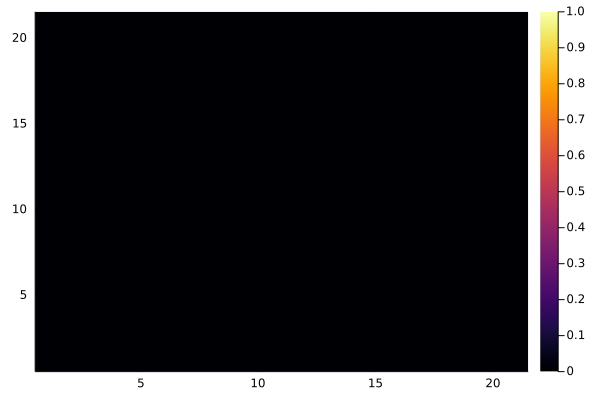

In [270]:
using Plots

heatmap(reshape(results[1][1], (21, 21)))

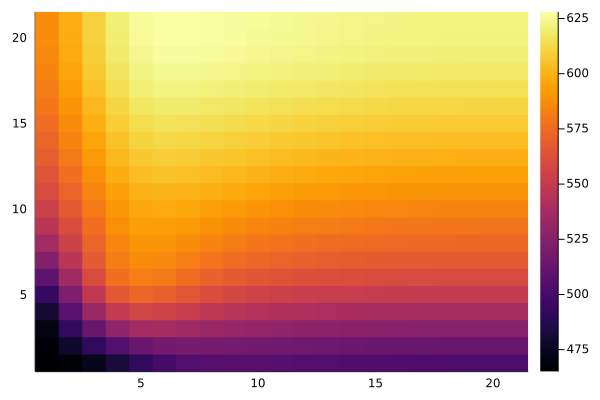

In [203]:
heatmap(reshape(results[1][2], (21, 21)))

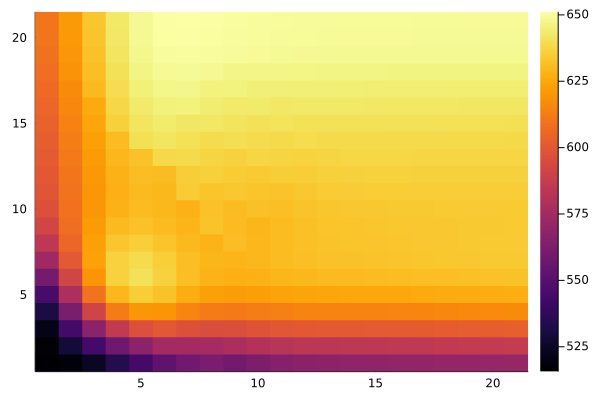

In [204]:
heatmap(reshape(results[1][3], (21, 21)))

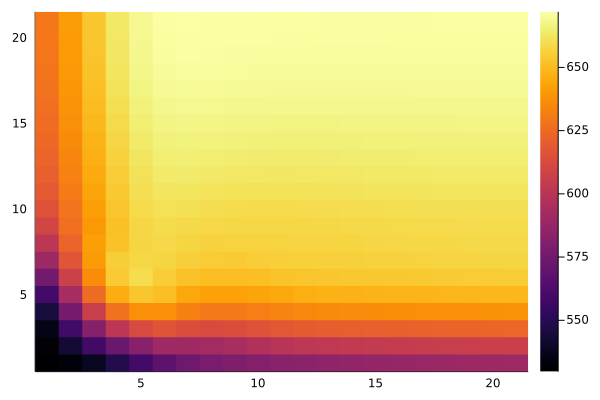

In [205]:
heatmap(reshape(results[1][4], (21, 21)))

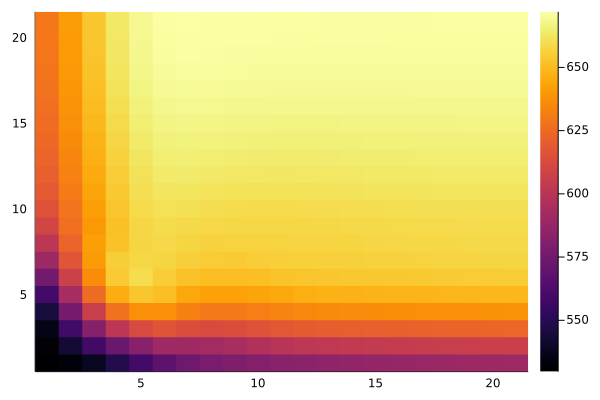

In [206]:
heatmap(reshape(results[1][4], (21, 21)))

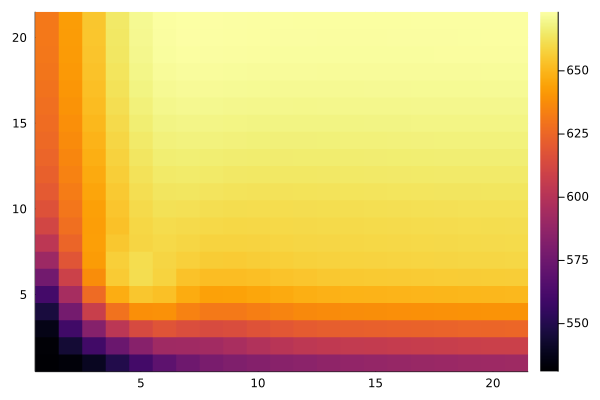

In [207]:
heatmap(reshape(results[1][5], (21, 21)))

In [215]:
results[2][5][state2ind((20, 20))]

Symbol("5")

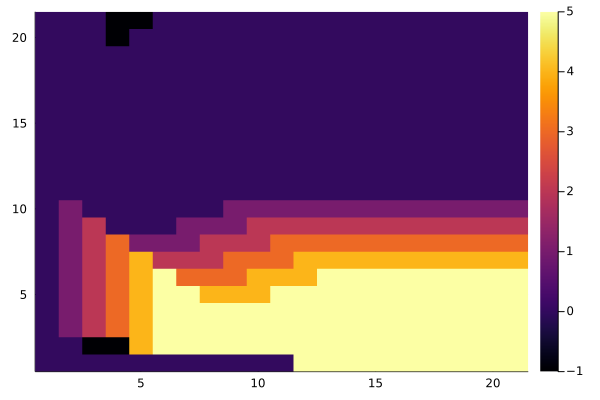

In [268]:
heatmap(reshape(parse.(Int64, String.(results[2][5])), (21, 21)))

> _Exercise 4.8_ Why does the optimal policy for the gambler's problem have such a curious form? In particular, for capital of 50, it bets it all on one flip, but for capital of 51, it does not. Why is this a good policy?

> _Exercise 4.9 (programming)_ Implement value iteration for the gambler's problem and solve it for $p_h = 0.25$ and $p_h = 0.55$. In programming, you may find it convenient to introduce two dummy states corresponding to termination with capital of 0 and 100, giving them values of 0 and 1 respectively. Show your results graphically, as in Figure 4.3. Are your results stable as $\theta \to 0$?

In [360]:
function gambler_value_iteration(p_h; θ=0.01, N=99)
    S = collect(1:N)
    𝒜(s) = collect(1:min(s, N + 1 - s))
    V = zeros(length(S) + 2)
    V[1] = 0 # V[0]
    V[end] = 1 # V[100]
    δ = Inf
    while δ > θ
        δ = -Inf
        for s in S
            v = V[s+1]
            V[s+1] = maximum(a -> V[s + a + 1]*p_h + V[s - a + 1]*(1-p_h), 𝒜(s))
            δ = max(δ, abs(v - V[s+1]))
        end
    end
    
    return V, s -> argmax(a -> V[s + a + 1]*p_h + V[s - a + 1]*(1-p_h), 𝒜(s))
end
        

gambler_value_iteration (generic function with 1 method)

In [365]:
V, π_gambler = gambler_value_iteration(0.51; θ=eps(Float64), N=999);

LoadError: InterruptException:

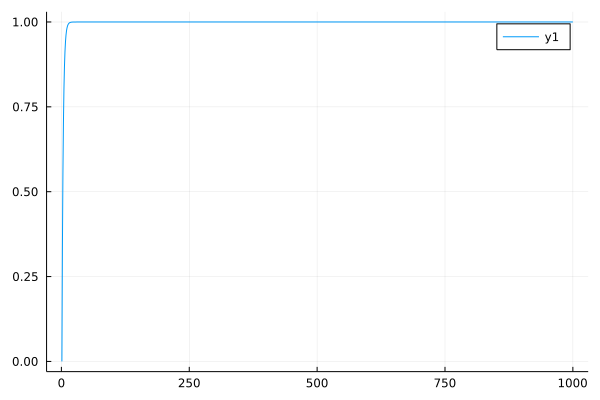

In [362]:
plot(V[1:end-1])

In [363]:
π_gambler(25)

1

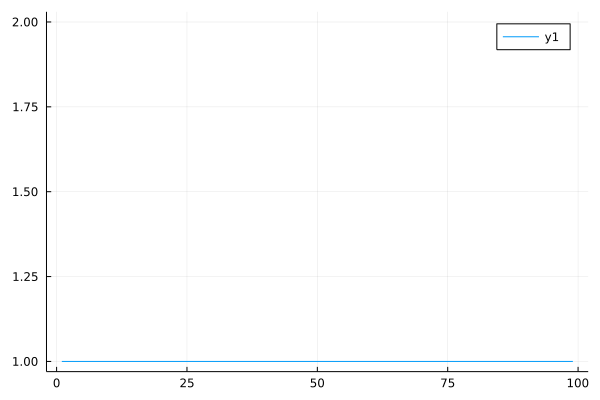

In [364]:
plot(collect(π_gambler(s) for s in 1:99))

> _Exercise 4.10_ What is the analog of the value iteration update (4.10) for action values $q_{k+1}(s, a)$?

$$
q_{k+1}(s, a) = \sum_{s',r}(p(s', r | s, a)\big(r + \max_{a'}q(s', a')\big)
$$